In [1]:
import numpy as np
import pandas as pd
import warnings as w
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from astropy.constants import h, c, e
from matplotlib.ticker import FuncFormatter
sns.set_style('darkgrid')
w.filterwarnings('ignore')

# Backbone

In [2]:
def float_formatter(x, pos):
    """
    Format a floating-point number with one decimal place.

    Parameters:
    - x (float): The floating-point number to be formatted.
    - pos (int): The tick position (ignored in this function).

    Returns:
    str: A formatted string representation of the floating-point number with one decimal place.
    """
    return f"{x:.1f}"

def float_formatter_aux(x, pos):
    """
    Format a floating-point number with one decimal place.

    Parameters:
    - x (float): The floating-point number to be formatted.
    - pos (int): The tick position (ignored in this function).

    Returns:
    str: A formatted string representation of the floating-point number with one decimal place.
    """
    return f"{x:.3f}"

def process_txt_file(file_path):
    """
    Process a text file containing tab-separated values and convert it into a DataFrame.

    Parameters:
    - file_path (str): The path to the text file.

    Returns:
    pd.DataFrame or None: The DataFrame containing the processed data or None in case of an error.
    """
    try:
        with open(file_path, 'r') as file:
            lines = file.readlines()

        table = []
        for line in lines:
            row = [float(value) if value.strip() != 'NAN' else np.nan for value in line.strip().split('\t')]
            table.append(row)

        df = pd.DataFrame(table)

        columns = [f'R_{i} [s⁻¹]' for i in range(0, 8)]
        df.columns = columns

        n_lambda = pd.Series(np.arange(24.0, 62.5), name='n_lambda [pm]')
        df.insert(0, 'lambda [pm]', n_lambda)

        return df

    except Exception as e:
        print(f"Error processing file: {e}")
        return None

def get_series_from_columns(dataframe, start_column, end_column):
    """
    Get a list of pd.Series from DataFrame columns within a specified range.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the columns.
    - start_column (str): The starting column name (inclusive).
    - end_column (str): The ending column name (inclusive).

    Returns:
    list: A list of pd.Series.
    """
    # Ensure the start and end columns exist in the DataFrame
    if start_column not in dataframe.columns or end_column not in dataframe.columns:
        raise ValueError("Invalid start_column or end_column.")

    # Get the index of the start and end columns
    start_index = dataframe.columns.get_loc(start_column)
    end_index = dataframe.columns.get_loc(end_column)

    # Return a list of pd.Series within the specified range
    return [dataframe.iloc[:, i] for i in range(start_index, end_index + 1)]

def find_best_points_and_regression(X, Y):
    """
    Find the best points for linear regression with a high incline.

    Parameters:
    - X (pd.Series): The independent variable series.
    - Y (pd.Series): The dependent variable series.

    Returns:
    tuple: A tuple containing the best points and linear regression.
        - best_points (tuple): Tuple of the best X and Y points.
        - best_regression (tuple): Tuple of slope and intercept for the linear regression.
    """
    # Drop NaN values
    mask = ~np.isnan(X) & ~np.isnan(Y)
    x_values = X[mask].values
    y_values = Y[mask].values

    best_points = None
    closest_angle_diff = float('inf')
    best_regression = None

    for i in range(len(x_values)):
        for j in range(i + 1, len(x_values)):
            for k in range(j + 1, len(x_values)):
                x_points = np.array([x_values[i], x_values[j], x_values[k]])
                y_points = np.array([y_values[i], y_values[j], y_values[k]])

                # Perform linear regression
                result = linregress(x_points, y_points)

                # Calculate the angle with the x-axis
                angle = np.degrees(np.arctan(result.slope))

                # Check the difference from 90°
                angle_diff = np.abs(angle - 90)

                # Update the best points and regression if the current triplet is closer to 90°
                if angle_diff < closest_angle_diff:
                    closest_angle_diff = angle_diff
                    best_points = (x_points, y_points)
                    best_regression = (result.slope, result.intercept)
                    stats = (result.slope, result.intercept, result.rvalue, result.pvalue, result.stderr, result.intercept_stderr)

    return best_points, best_regression, stats
    
def regression_line(best_regression, X):
    """
    Compute the linear regression line.

    Parameters:
    - best_regression (tuple): Tuple of slope and intercept for the linear regression.
    - X (pd.Series): The independent variable series.

    Returns:
    pd.Series: The predicted values for the linear regression line.
    """
    return best_regression[0] * X + best_regression[1]

def lambda_min(U):
    """
    Calculate the minimum wavelength for a given voltage in a Molybdenum (Mo) emission curve.

    Parameters:
    - U (float): Voltage applied to the Molybdenum tube in kilovolts.

    Returns:
    float: Minimum wavelength in meters.
    """
    return (h.value * c.value / e.value) / U 

In [3]:
file_path = 'duane_hunt_R.txt'
df = process_txt_file(file_path)
df.index += 1
Y_series = get_series_from_columns(df, 'R_0 [s⁻¹]', 'R_7 [s⁻¹]')
U = [22., 24., 26., 28., 30., 32., 34., 35.] # kV

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 1 to 38
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   lambda [pm]  38 non-null     float64
 1   R_0 [s⁻¹]    11 non-null     float64
 2   R_1 [s⁻¹]    13 non-null     float64
 3   R_2 [s⁻¹]    18 non-null     float64
 4   R_3 [s⁻¹]    23 non-null     float64
 5   R_4 [s⁻¹]    29 non-null     float64
 6   R_5 [s⁻¹]    36 non-null     float64
 7   R_6 [s⁻¹]    36 non-null     float64
 8   R_7 [s⁻¹]    36 non-null     float64
dtypes: float64(9)
memory usage: 2.8 KB


In [4]:
df.describe().round(2)

,lambda [pm],R_0 [s⁻¹],R_1 [s⁻¹],R_2 [s⁻¹],R_3 [s⁻¹],R_4 [s⁻¹],R_5 [s⁻¹],R_6 [s⁻¹],R_7 [s⁻¹]
count,38.00,11.00,13.00,18.00,23.00,29.00,36.00,36.00,36.00
mean,42.50,85.50,130.95,151.04,149.25,165.51,179.01,224.84,236.66
std,11.11,17.26,28.02,55.00,91.05,120.54,145.97,167.01,171.13
min,24.00,56.27,75.93,45.70,16.45,13.80,15.60,18.30,19.40
25%,33.25,76.32,115.47,113.40,53.68,26.70,21.55,26.52,29.40
50%,42.50,90.27,143.70,175.00,192.25,200.00,190.20,293.50,317.05
75%,51.75,98.78,147.37,187.96,225.00,282.30,334.18,386.88,392.40
max,61.00,100.90,162.67,221.95,271.05,333.50,386.40,440.10,452.90


In [5]:
df.to_excel('DuaneHunt_R.xlsx', sheet_name='experimental_data')

## Statistics of the columns $\lambda$, $R_{i}$

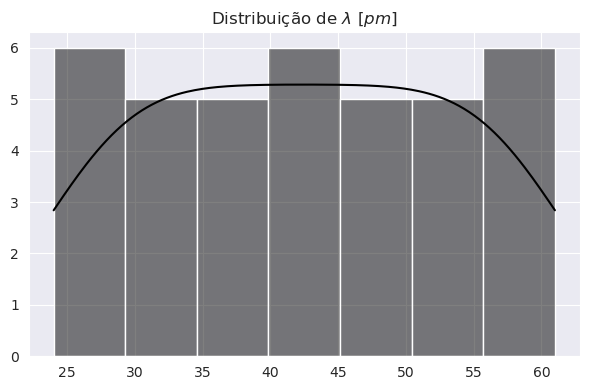

In [6]:
fig = plt.figure(figsize=(6, 4))

sns.histplot(df['lambda [pm]'], kde=True, color='black')
plt.title(r'Distribuição de $\lambda$ $[pm]$')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

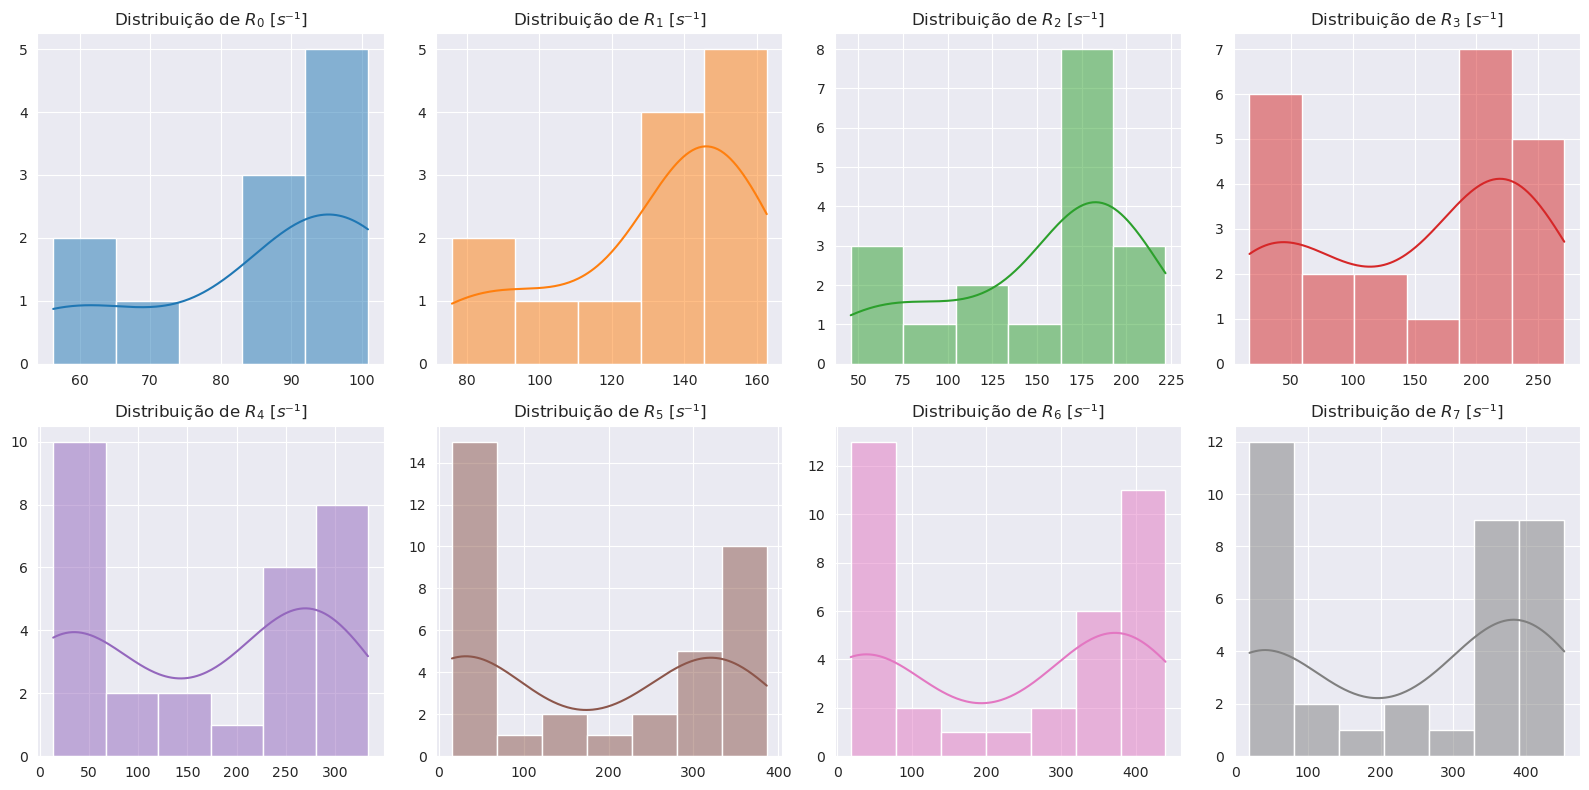

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

axes = axes.flatten()
colors = sns.color_palette('tab10', n_colors=len(Y_series))


for i, (Y, ax, color) in enumerate(zip(Y_series, axes, colors)):
    sns.histplot(Y, kde=True, ax=ax, color=color)
    ax.set_title(fr'Distribuição de ${Y.name.split()[0]}\ {Y.name.split()[1]}$')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

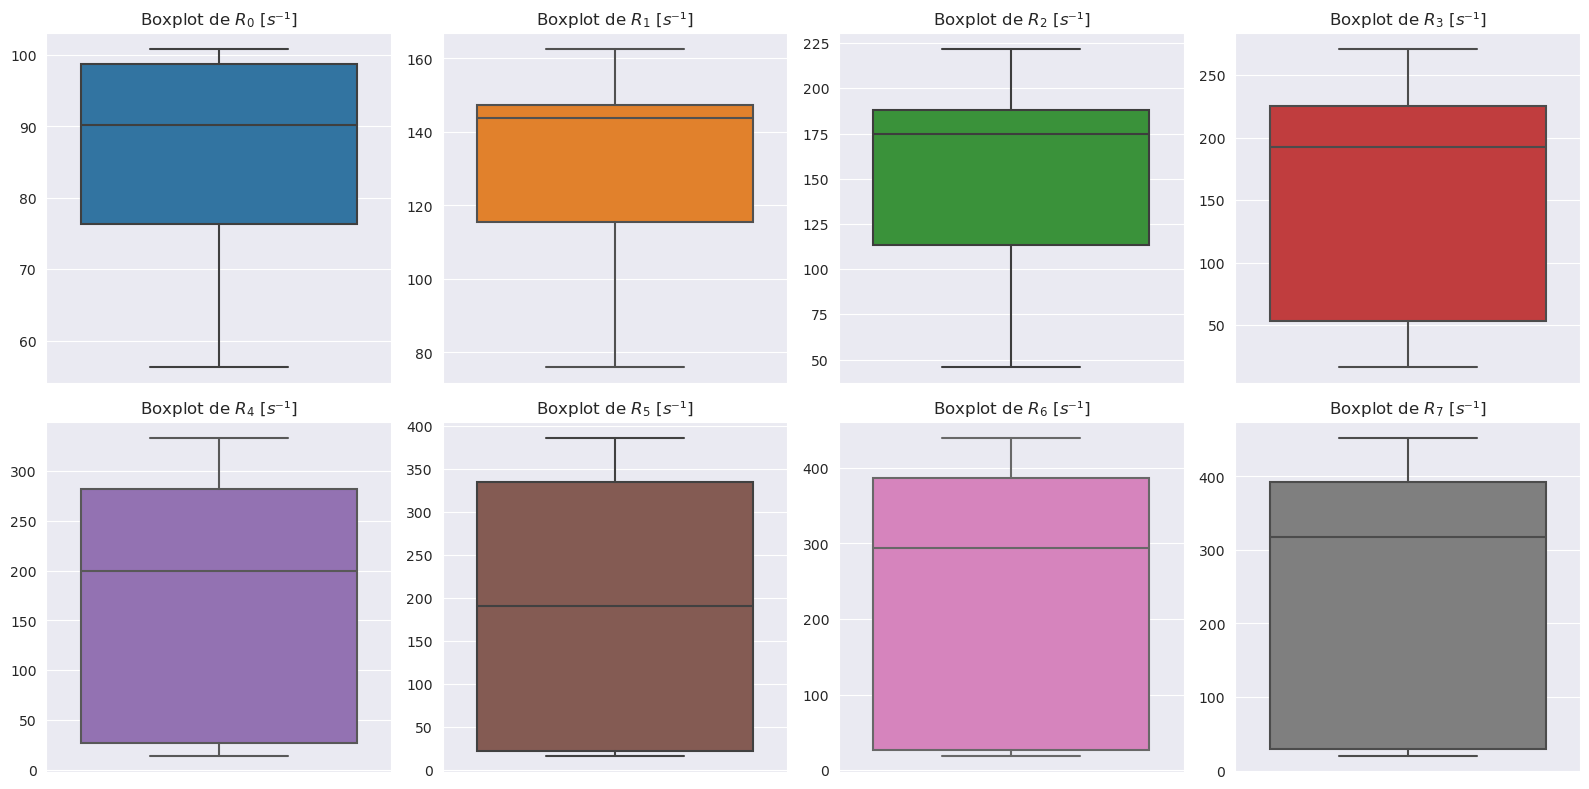

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, (Y, ax, color) in enumerate(zip(Y_series, axes, colors)):
    sns.boxplot(y=Y, ax=ax, color=color)
    ax.set_title(fr'Boxplot de ${Y.name.split()[0]}\ {Y.name.split()[1]}$')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

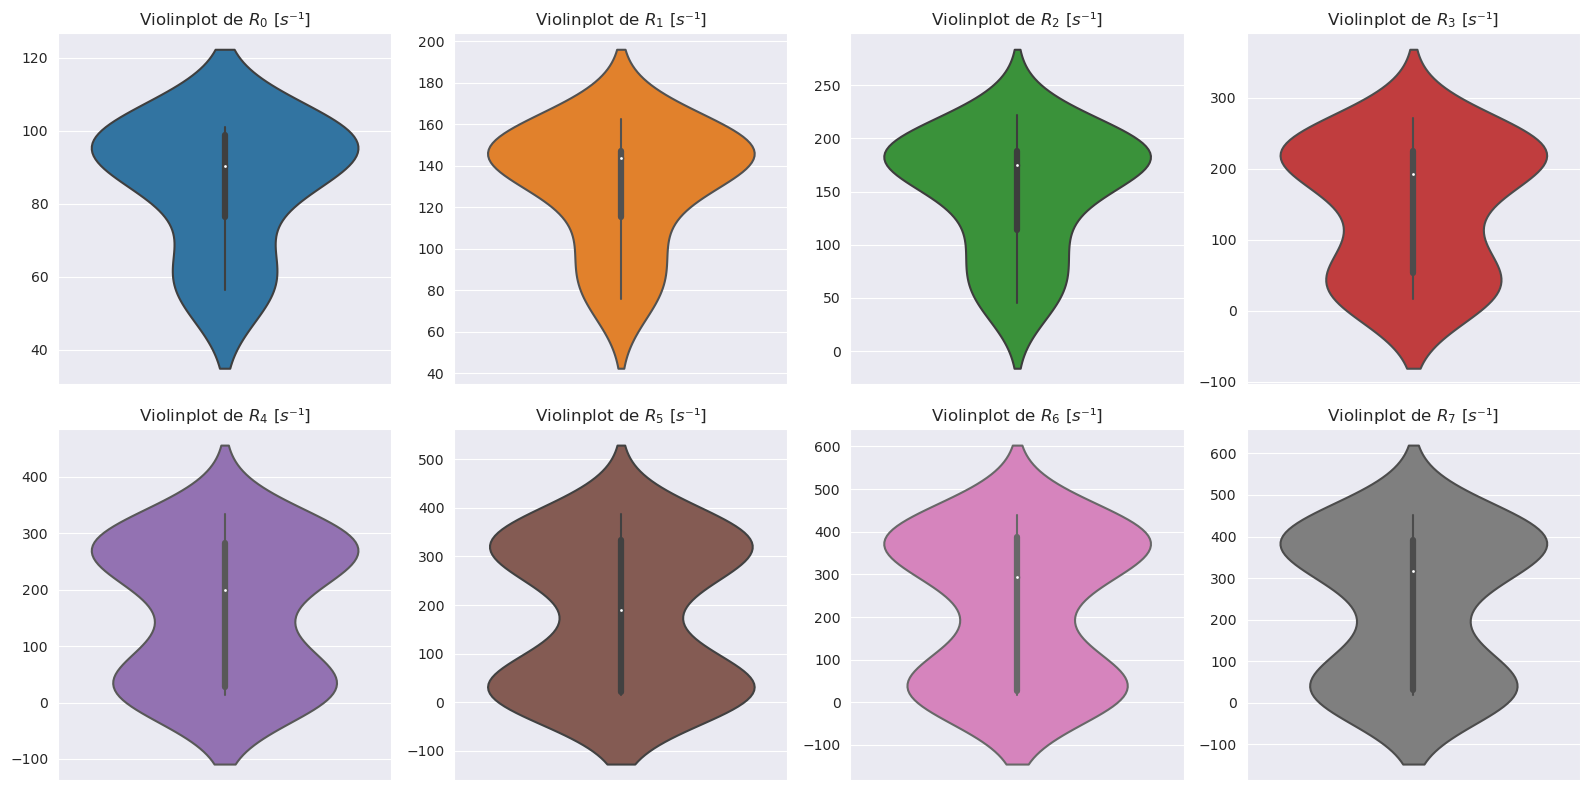

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through the pandas Series and plot violin plots with different colors
for i, (Y, ax, color) in enumerate(zip(Y_series, axes, colors)):
    sns.violinplot(y=Y, ax=ax, color=color)
    ax.set_title(fr'Violinplot de ${Y.name.split()[0]}\ {Y.name.split()[1]}$')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

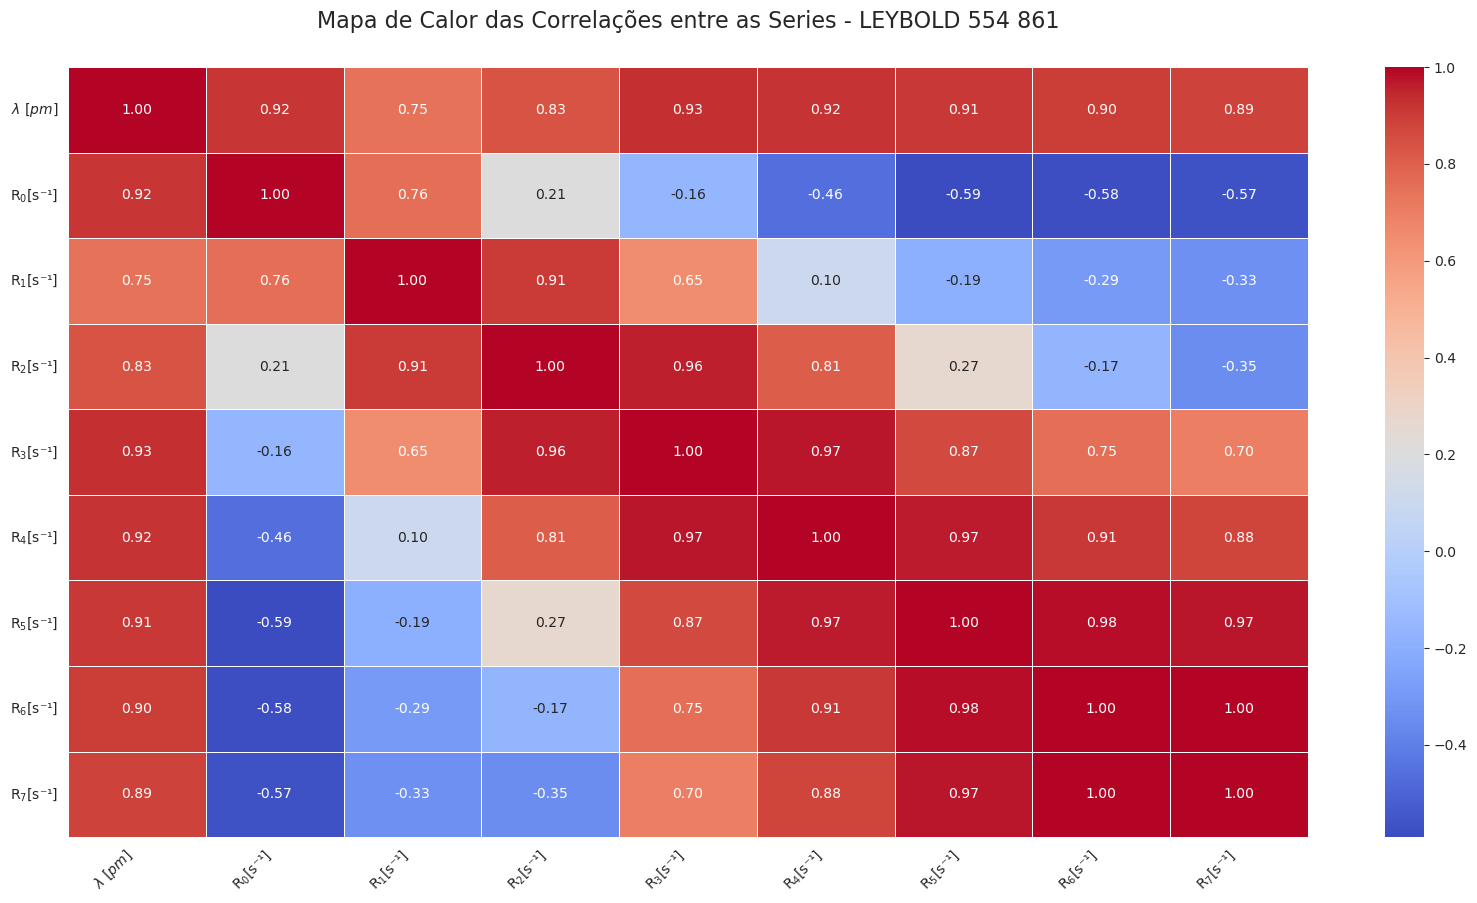

In [10]:
df_corr = df.corr()

# Increase figure size
f, ax = plt.subplots(figsize=(20, 10))
plt.title('Mapa de Calor das Correlações entre as Series - LEYBOLD 554 861', y=1.04, fontsize=16)

# Create a heatmap with LaTeX-formatted labels
heatmap = sns.heatmap(
    df_corr, 
    annot=True, 
    cmap='coolwarm', 
    linewidths=.5, 
    fmt=".2f", 
    ax=ax,
    xticklabels=[r'$\mathrm{%s}$' % col for col in df_corr.columns],
    yticklabels=[r'$\mathrm{%s}$' % row for row in df_corr.index]
)

# Defina o novo rótulo desejado
old_label = '$\\mathrm{lambda [pm]}$'
new_label = r'$\lambda$ $[pm]$'

# Obtenha os rótulos atuais
current_labels = [label.get_text() for label in heatmap.get_xticklabels()]

# Substitua o rótulo desejado
if old_label in current_labels:
    index_to_replace = current_labels.index(old_label)
    current_labels[index_to_replace] = new_label

# Configure os novos rótulos
heatmap.set_xticklabels(current_labels)
heatmap.set_yticklabels(current_labels)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

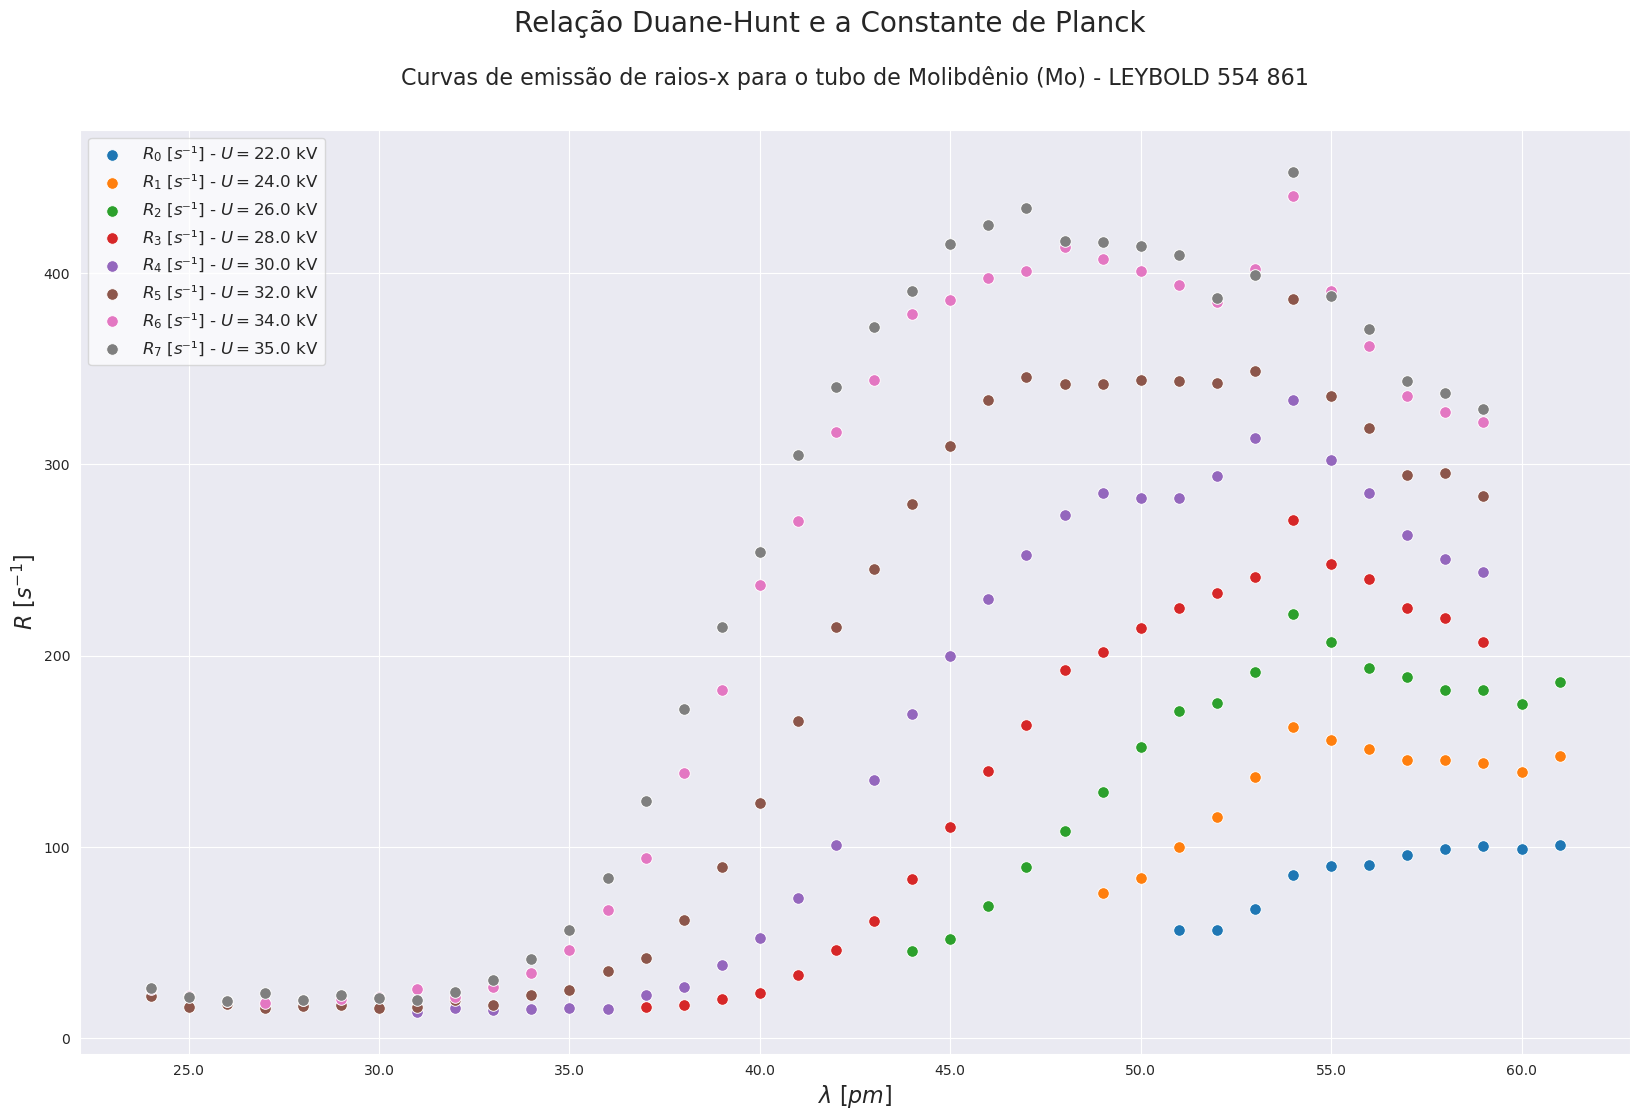

In [11]:
f = plt.figure(figsize=(20, 12))
plt.suptitle('Relação Duane-Hunt e a Constante de Planck', fontsize=20)
plt.title('Curvas de emissão de raios-x para o tubo de Molibdênio (Mo) - LEYBOLD 554 861', y=1.04, fontsize=16)

for i, Y in enumerate(Y_series):
    sns.scatterplot(x='lambda [pm]', y=Y, data=df, s=70, label=fr'$R_{i}$ $[s⁻¹]$ - $U = {U[i]}$ kV')

plt.xlabel(r'$\lambda$ [$pm$]', fontsize=16)
plt.ylabel(r'$R\ [s^{-1}]$', fontsize=16)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large', loc='upper left')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.savefig('DuaneHunt_1_scatter.pdf')
plt.show()

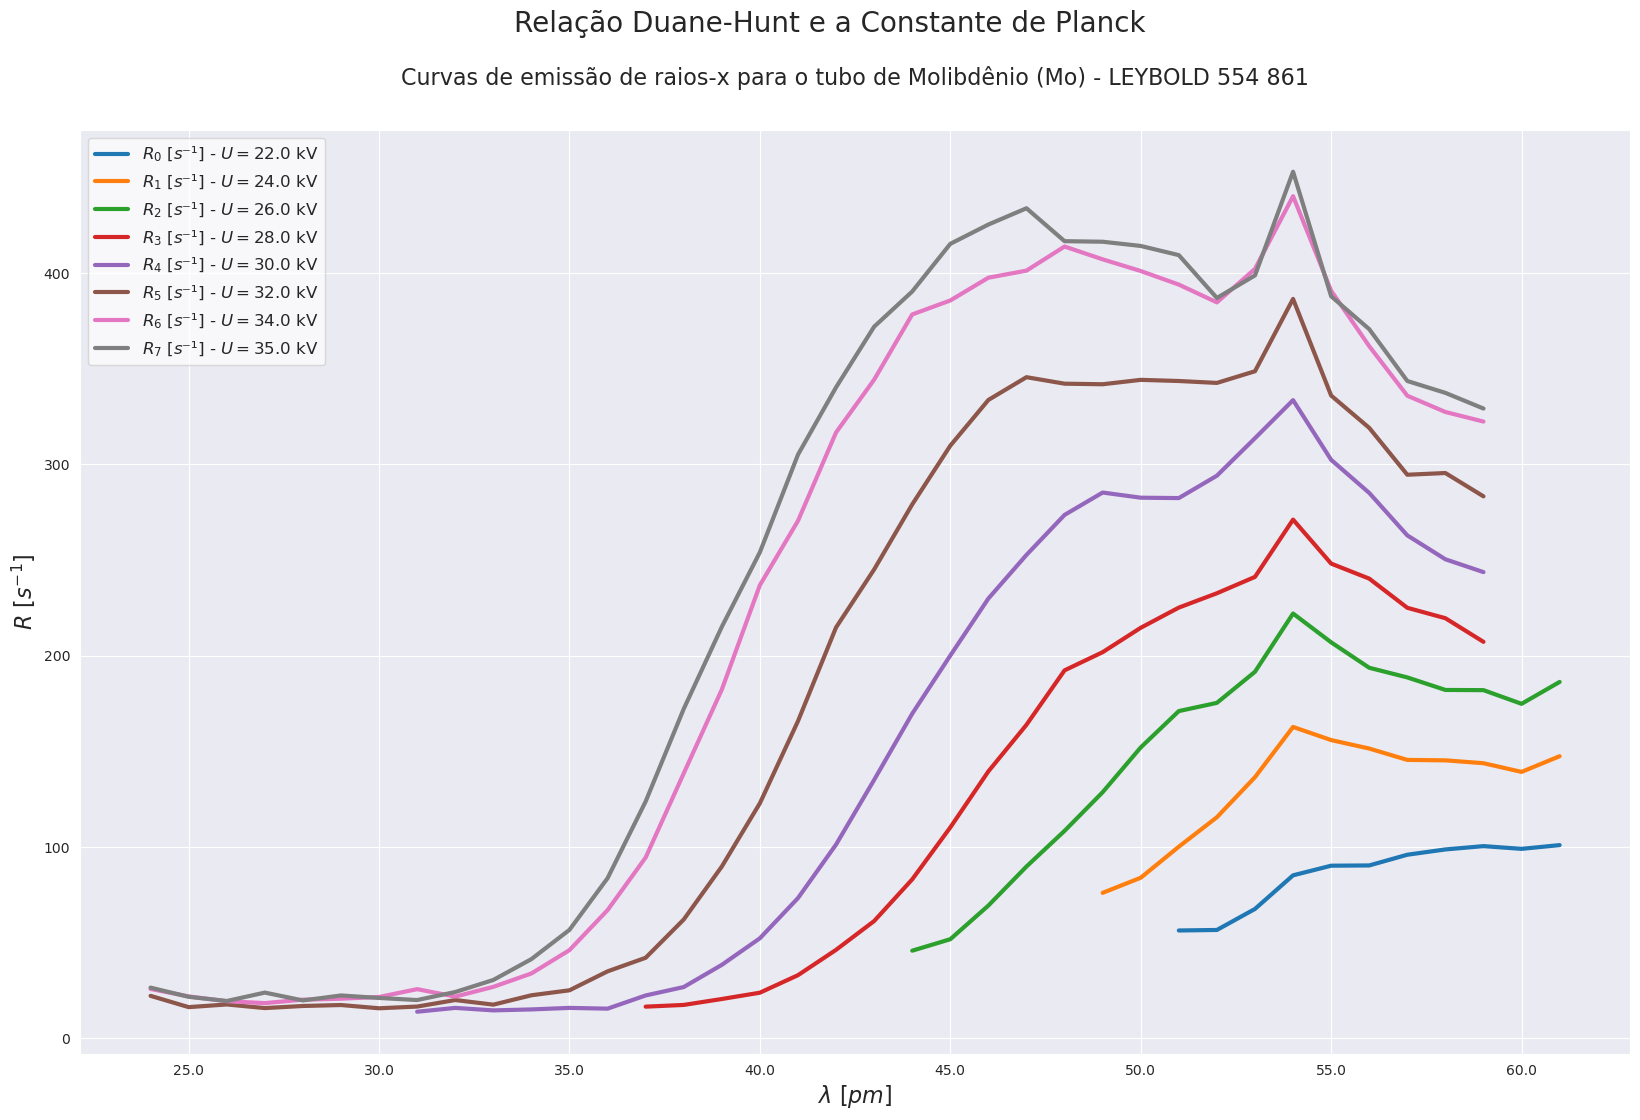

In [12]:
f = plt.figure(figsize=(20, 12))
plt.suptitle('Relação Duane-Hunt e a Constante de Planck', fontsize=20)
plt.title('Curvas de emissão de raios-x para o tubo de Molibdênio (Mo) - LEYBOLD 554 861', y=1.04, fontsize=16)

for i, Y in enumerate(Y_series):
    sns.lineplot(x='lambda [pm]', y=Y, data=df, lw=3, label=fr'$R_{i}$ $[s⁻¹]$ - $U = {U[i]}$ kV')

plt.xlabel(r'$\lambda$ [$pm$]', fontsize=16)
plt.ylabel(r'$R\ [s^{-1}]$', fontsize=16)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large', loc='upper left')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.savefig('DuaneHunt_1_line.pdf')
plt.show()

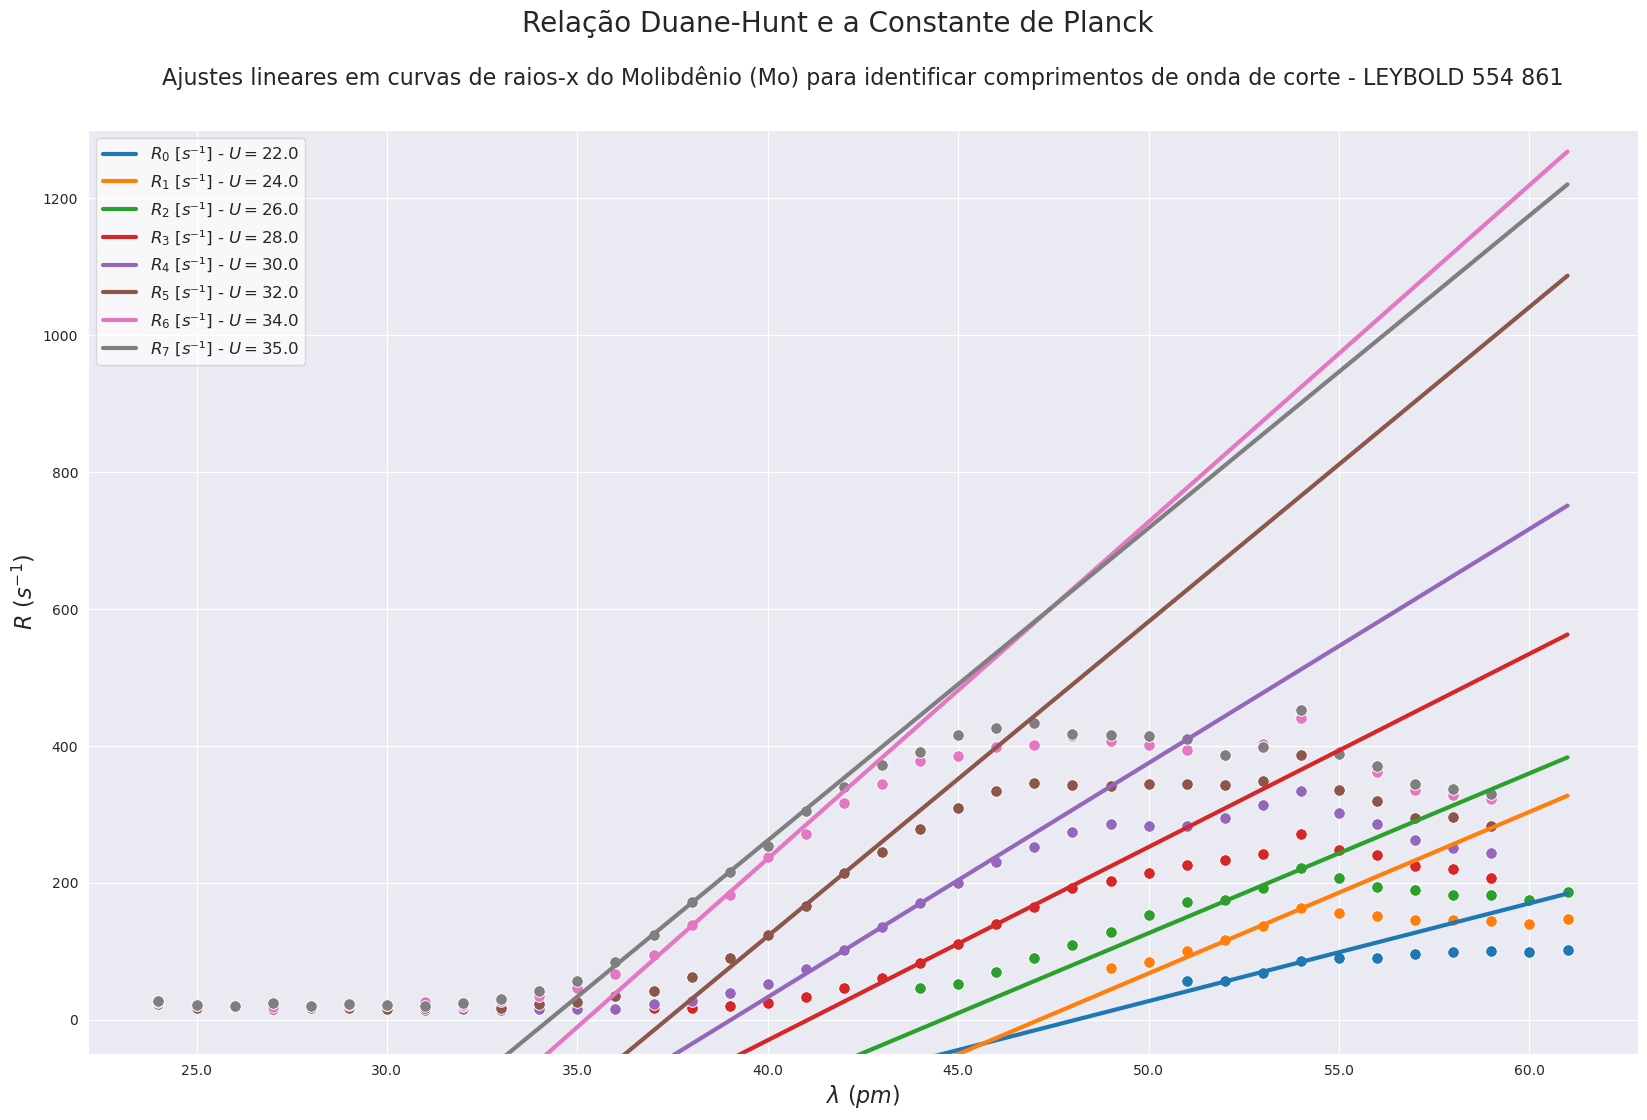

In [13]:
f = plt.figure(figsize=(20, 12))
plt.suptitle('Relação Duane-Hunt e a Constante de Planck', fontsize=20)
plt.title('Ajustes lineares em curvas de raios-x do Molibdênio (Mo) para identificar comprimentos de onda de corte - LEYBOLD 554 861', y=1.04, fontsize=16)
X = df['lambda [pm]']
i = 0
reg_stats = {}

for Y in Y_series:
    reg_stats[Y.name] = {}
    _, best_regression, stats = find_best_points_and_regression(X, Y)
    reg_stats[Y.name]['slope'] = stats[0]
    reg_stats[Y.name]['intercept'] = stats[1]
    reg_stats[Y.name]['rvalue'] = stats[2]
    reg_stats[Y.name]['pvalue'] = stats[3]
    reg_stats[Y.name]['stderr'] = stats[4]
    reg_stats[Y.name]['intercept_stderr'] = stats[5]
    predicted_values = regression_line(best_regression, X)
    mask = ~np.isnan(Y) & ~np.isnan(predicted_values)
    sns.scatterplot(x=X, y=Y, data=df, s=70)
    plt.plot(X, predicted_values, lw=3, label=fr'${Y.name.split()[0]}$ ${Y.name.split()[1]}$ - $U = {U[i]}$')
    i += 1

plt.ylim(-50, 1300)
plt.xlabel(r'$\lambda$ ($pm$)', fontsize=16)
plt.ylabel(r'$R\ (s^{-1})$', fontsize=16)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter))
plt.savefig('DuaneHunt_2.pdf')
plt.show()

In [14]:
stats = pd.DataFrame(
    reg_stats
)

df.to_excel('DuaneHunt_regressions.xlsx', sheet_name='experimental_regressions_result')
stats

,R_0 [s⁻¹],R_1 [s⁻¹],R_2 [s⁻¹],R_3 [s⁻¹],R_4 [s⁻¹],R_5 [s⁻¹],R_6 [s⁻¹],R_7 [s⁻¹]
slope,14.283333,23.600000,23.350000,28.225000,34.200000,45.950000,49.200000,45.650000
intercept,-687.294445,-1112.622222,-1041.316667,-1159.258333,-1335.333333,-1716.216667,-1733.000000,-1564.433333
rvalue,0.991308,0.997879,0.984938,0.999758,0.999977,0.999267,0.997998,0.999396
pvalue,0.083999,0.041473,0.110634,0.013997,0.004299,0.024385,0.040287,0.022133
stderr,1.895633,1.539601,4.099187,0.620652,0.230940,1.760918,3.117691,1.587713
intercept_stderr,100.480491,81.608522,217.282686,27.933916,9.932215,72.211966,121.616611,60.347029


# Building $\lambda_{min}$ x $\frac{1}{U}$

In [15]:
df_aux = pd.DataFrame(
    {
        '1 / U [kV]' : [1 / U[i] for i in range(len(U))],
        'lambda_min [pm]' : [58.7, 56.0, 44.7, 37.4, 29.5, 26.1, 24.1, 13.8],
        'theoretical_lambda_min [pm]' : lambda_min(U) * 10e8
    }
)

df_aux.to_excel('DuaneHunt_(1_U)_x_lambda_min.xlsx', sheet_name='experimental_data')
df_aux

,1 / U [kV],lambda_min [pm],theoretical_lambda_min [pm]
0,0.045455,58.7,56.356454
1,0.041667,56.0,51.660083
2,0.038462,44.7,47.686230
3,0.035714,37.4,44.280071
4,0.033333,29.5,41.328066
5,0.031250,26.1,38.745062
6,0.029412,24.1,36.465941
7,0.028571,13.8,35.424057


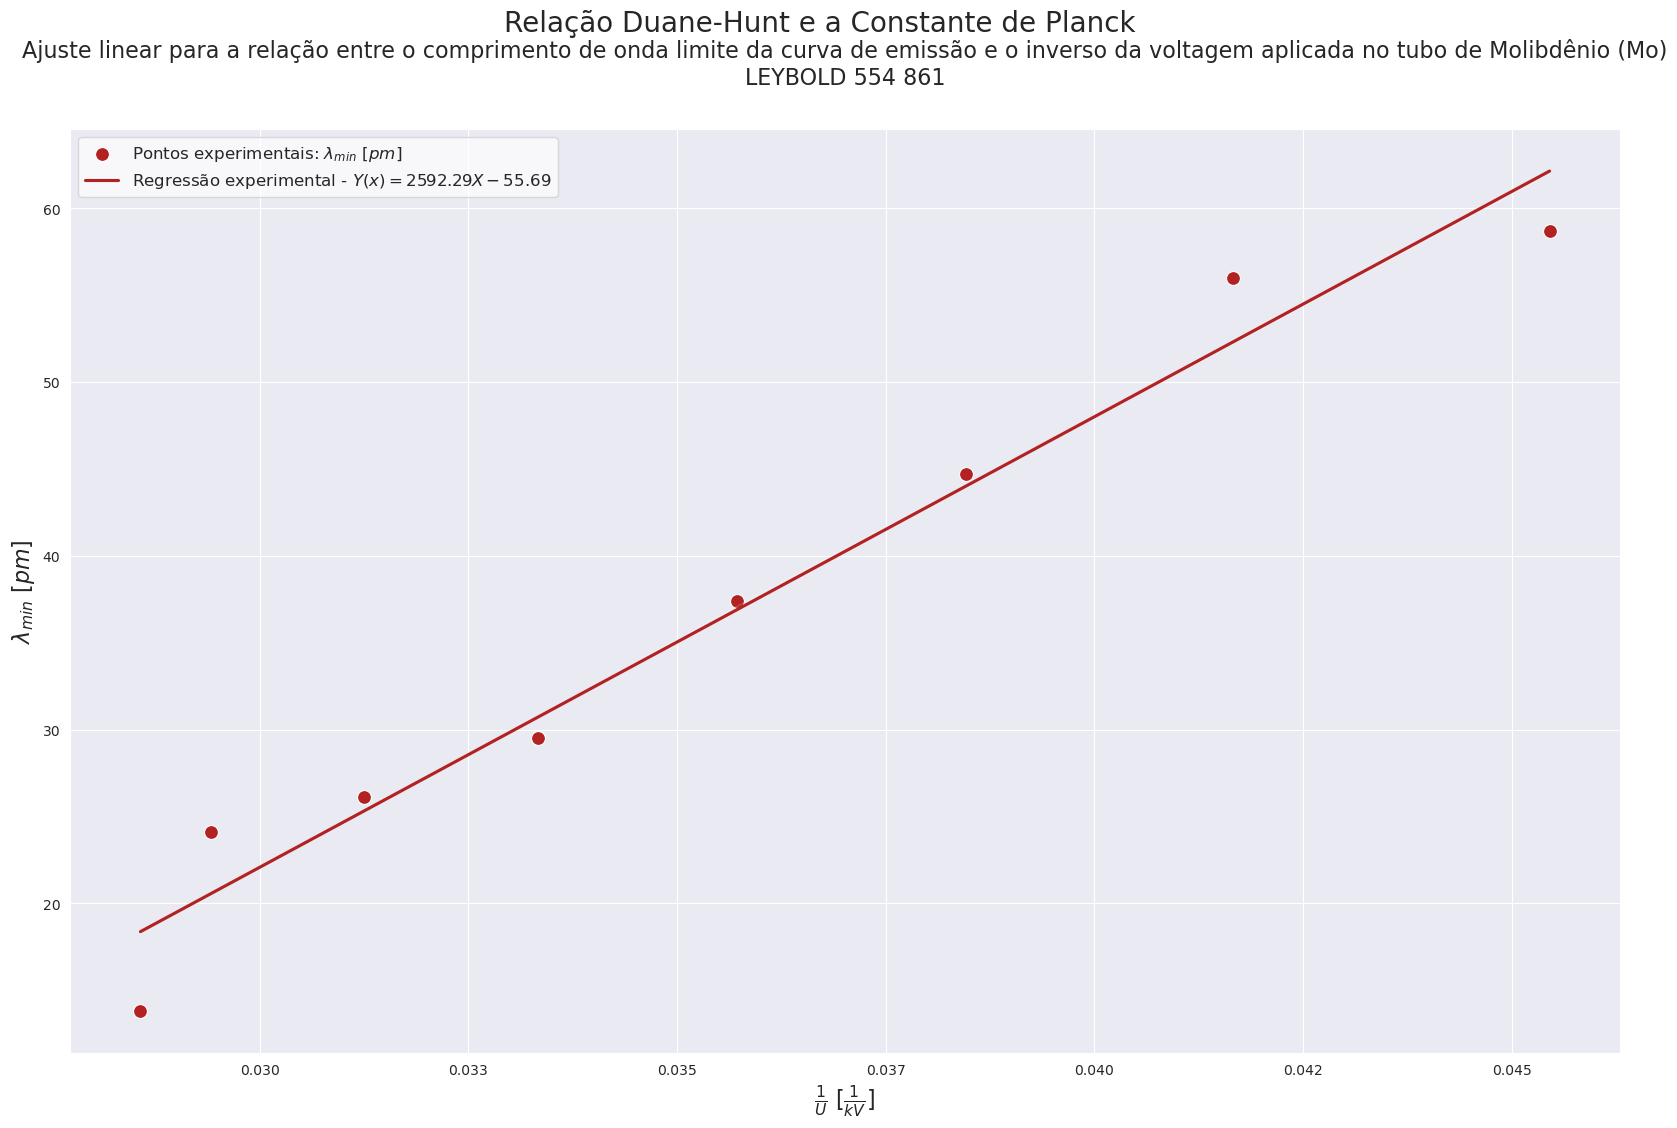

In [16]:
f = plt.figure(figsize=(20, 12))
plt.suptitle('Relação Duane-Hunt e a Constante de Planck', fontsize=20)
plt.title('Ajuste linear para a relação entre o comprimento de onda limite da curva de emissão e o inverso da voltagem aplicada no tubo de Molibdênio (Mo)\nLEYBOLD 554 861', y=1.04, fontsize=16)
X = df_aux['1 / U [kV]']
Y = df_aux['lambda_min [pm]']
i = 0
reg_stats_aux = {'lambda_min [pm]' : {}}

result = linregress(X, Y)
reg_stats_aux['lambda_min [pm]']['slope'] = result.slope
reg_stats_aux['lambda_min [pm]']['intercept'] = result.intercept
reg_stats_aux['lambda_min [pm]']['rvalue'] = result.rvalue
reg_stats_aux['lambda_min [pm]']['pvalue'] = result.pvalue
reg_stats_aux['lambda_min [pm]']['stderr'] = result.stderr
reg_stats_aux['lambda_min [pm]']['intercept_stderr'] = result.intercept_stderr

sns.scatterplot(x='1 / U [kV]', y='lambda_min [pm]', data=df_aux, s=100, color='firebrick', label=r'Pontos experimentais: $\lambda_{min}\ [pm]$')
sns.regplot(x='1 / U [kV]', y='lambda_min [pm]', data=df_aux, ci=0, color='firebrick', label=fr'Regressão experimental - $Y(x) = {reg_stats_aux["lambda_min [pm]"]["slope"]:.2f}X {reg_stats_aux["lambda_min [pm]"]["intercept"]:.2f}$', scatter=False)

plt.xlabel(r'$\frac{1}{U}$ [$\frac{1}{kV}$]', fontsize=16)
plt.ylabel(r'$\lambda_{min}\ [pm]$', fontsize=16)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large', loc='upper left')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter_aux))
plt.savefig('DuaneHunt_3.pdf')
plt.show()

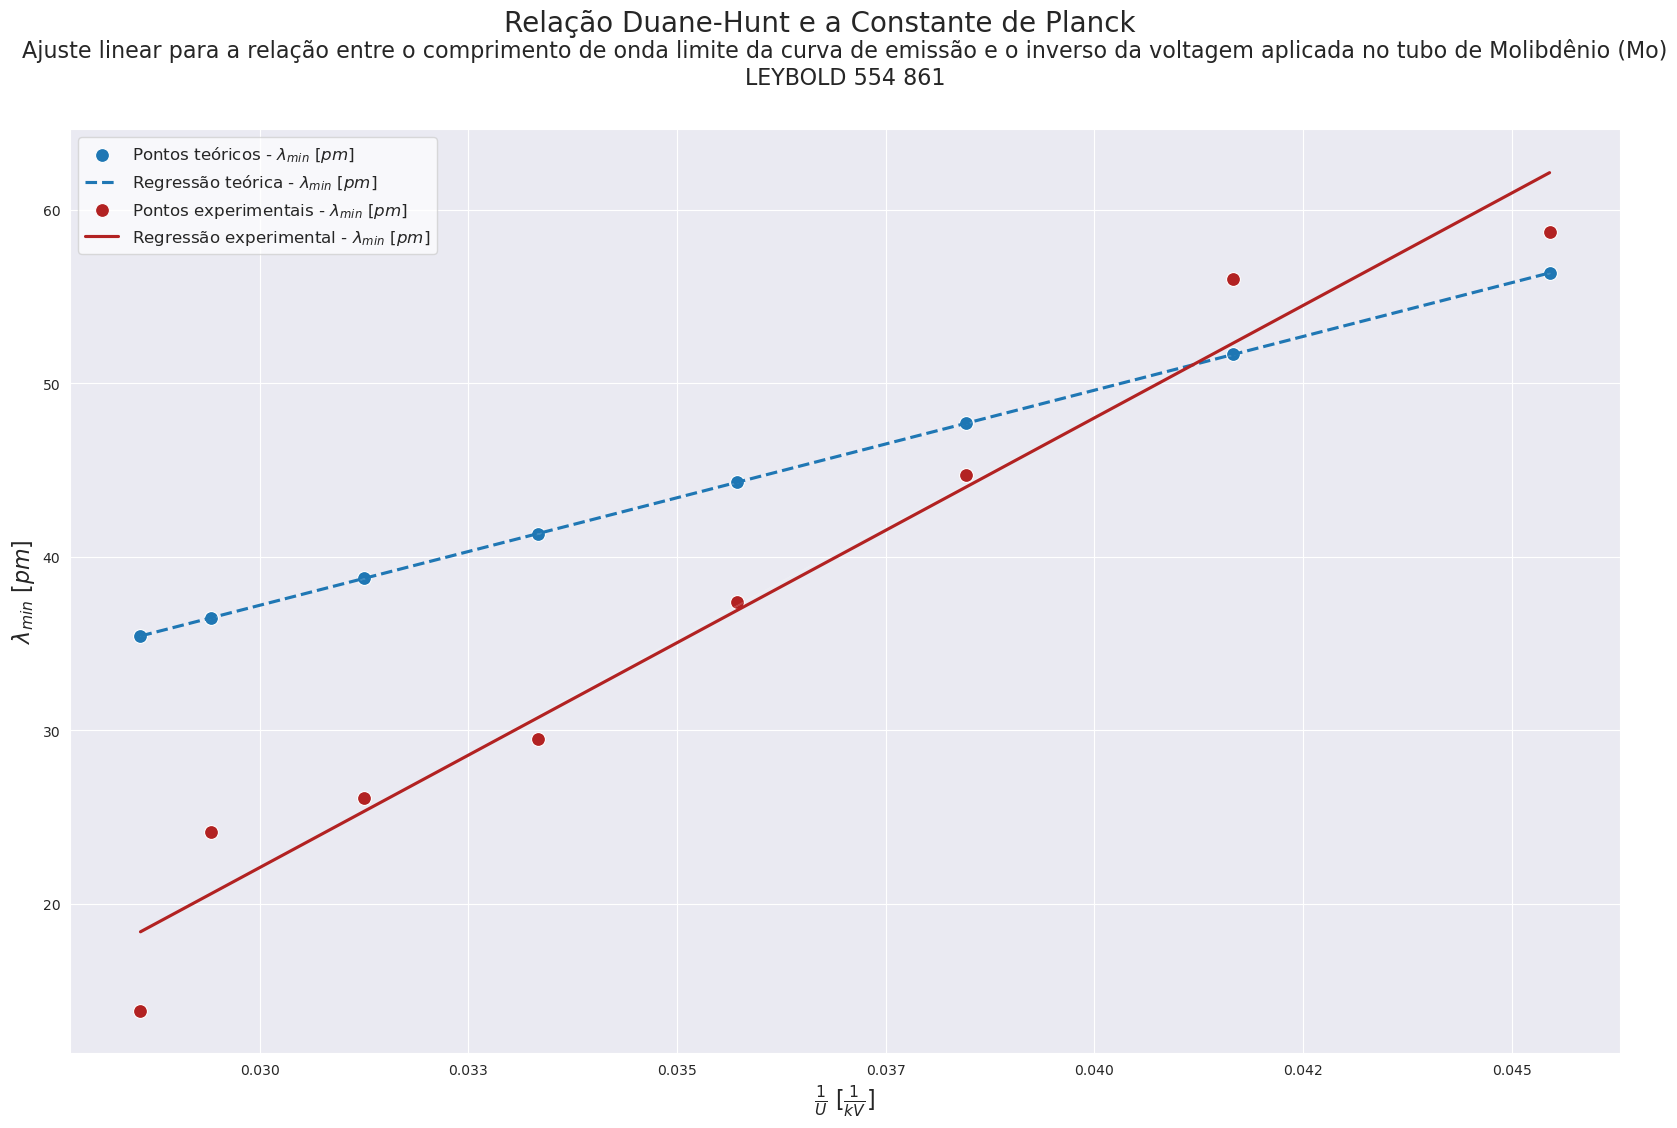

In [17]:
f = plt.figure(figsize=(20, 12))
plt.suptitle('Relação Duane-Hunt e a Constante de Planck', fontsize=20)
plt.title('Ajuste linear para a relação entre o comprimento de onda limite da curva de emissão e o inverso da voltagem aplicada no tubo de Molibdênio (Mo)\nLEYBOLD 554 861', y=1.04, fontsize=16)
X = df_aux['1 / U [kV]']
Y = df_aux['lambda_min [pm]']
i = 0
reg_stats_aux = {'lambda_min [pm]' : {}}

result = linregress(X, Y)
reg_stats_aux['lambda_min [pm]']['slope'] = result.slope
reg_stats_aux['lambda_min [pm]']['intercept'] = result.intercept
reg_stats_aux['lambda_min [pm]']['rvalue'] = result.rvalue
reg_stats_aux['lambda_min [pm]']['pvalue'] = result.pvalue
reg_stats_aux['lambda_min [pm]']['stderr'] = result.stderr
reg_stats_aux['lambda_min [pm]']['intercept_stderr'] = result.intercept_stderr

sns.scatterplot(x='1 / U [kV]', y='theoretical_lambda_min [pm]', data=df_aux, s=100, label=r'Pontos teóricos - $\lambda_{min}\ [pm]$')
sns.regplot(x=X, y='theoretical_lambda_min [pm]', data=df_aux, label=r'Regressão teórica - $\lambda_{min}\ [pm]$', line_kws={'linestyle': 'dashed'}, scatter=False)
sns.scatterplot(x='1 / U [kV]', y='lambda_min [pm]', data=df_aux, s=100, color='firebrick', label=r'Pontos experimentais - $\lambda_{min}\ [pm]$')
sns.regplot(x='1 / U [kV]', y='lambda_min [pm]', data=df_aux, ci=0, color='firebrick', label=r'Regressão experimental - $\lambda_{min}\ [pm]$', scatter=False)

plt.xlabel(r'$\frac{1}{U}$ [$\frac{1}{kV}$]', fontsize=16)
plt.ylabel(r'$\lambda_{min}\ [pm]$', fontsize=16)
plt.legend(frameon=True, facecolor='white', framealpha=0.7, fontsize='large', loc='upper left')
plt.gca().xaxis.set_major_formatter(FuncFormatter(float_formatter_aux))
plt.savefig('DuaneHunt_3_theoretical_experimental.pdf')
plt.show()

In [18]:
stats_aux = pd.DataFrame(reg_stats_aux)

stats_aux.to_excel('DuaneHunt_(1_U)_x_lambda_min_regression.xlsx', sheet_name='experimental_results')
stats_aux

,lambda_min [pm]
intercept,-55.694531
intercept_stderr,7.232677
pvalue,0.000013
rvalue,0.982384
slope,2592.288489
stderr,201.315108


In [19]:
X = df_aux['1 / U [kV]']
Y = df_aux['theoretical_lambda_min [pm]']
i = 0
reg_stats_theoretical = {'theoretical_lambda_min [pm]' : {}}

result = linregress(X, Y)
reg_stats_theoretical['theoretical_lambda_min [pm]']['slope'] = result.slope
reg_stats_theoretical['theoretical_lambda_min [pm]']['intercept'] = result.intercept
reg_stats_theoretical['theoretical_lambda_min [pm]']['rvalue'] = result.rvalue
reg_stats_theoretical['theoretical_lambda_min [pm]']['pvalue'] = result.pvalue
reg_stats_theoretical['theoretical_lambda_min [pm]']['stderr'] = result.stderr
reg_stats_theoretical['theoretical_lambda_min [pm]']['intercept_stderr'] = result.intercept_stderr

stats_theoretical = pd.DataFrame(reg_stats_theoretical)
stats_theoretical

,theoretical_lambda_min [pm]
intercept,-7.105427e-15
intercept_stderr,0.000000e+00
pvalue,2.500000e-60
rvalue,1.000000e+00
slope,1.239842e+03
stderr,0.000000e+00


# Constante de Planck

In [20]:
h_result = (e.value / c.value) * (reg_stats_aux['lambda_min [pm]']['slope']) * 10e-11
h_result_theoretical = (e.value / c.value) * (reg_stats_theoretical['theoretical_lambda_min [pm]']['slope']) * 10e-10
print('Constante de Planck obtida pela teoria:', h_result_theoretical, r' m² kg / s')
print('Constante de Planck obtida pelo experimento:', h_result, r' m² kg / s')

Constante de Planck obtida pela teoria: 6.626070150000001e-34  m² kg / s
Constante de Planck obtida pelo experimento: 1.3853931062843521e-34  m² kg / s
